# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

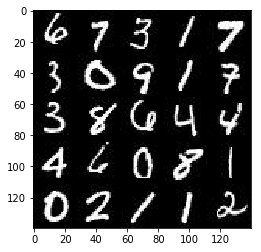

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

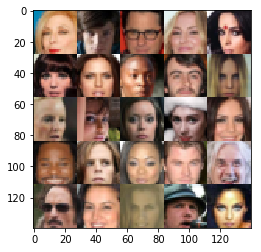

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #hidden layor
        alpha = 0.2
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        #leaky Relu
        h1 = tf.maximum(alpha*h1, h1)
        #output is 14x14x32
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)
        #output is 7x7x64
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3, h3)
        #output is 4x4x128
        
        flat = tf.reshape(h3, [-1, 4*4*512])
        
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        x1 = tf.layers.dense(z, 7*7*128) ## need to puzzle out dimensions
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #output is 7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, 56, 5, strides=2, padding='same') ## dimensions
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #output is 14x14x56
        

        x3 = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same') #dimensions
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x2, x2)
        #output is 28x28x3
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same') #dimensions
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim, is_train=True)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_real, 
                                                                          labels = tf.ones_like(dis_logits_real)*(1-.1)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake,
                                                                          labels = tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    
    gen_loss = tf.reduce_mean(tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = dis_logits_fake,
                                                                                    labels = tf.ones_like(dis_logits_fake))))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    dis_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    
    dis_train_opt, gen_train_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    step = 0
    losses=[]
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step+=1
                # TODO: Train Model
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_train_opt, feed_dict={input_real: batch_images, input_z: z, lr: learning_rate})
                _ = sess.run(gen_train_opt, feed_dict={input_real: batch_images, input_z: z, lr: learning_rate})
                _ = sess.run(gen_train_opt, feed_dict={input_real: batch_images, input_z: z, lr: learning_rate})
                
                
                if (step % 10 == 0):
                    train_loss_dis = dis_loss.eval({input_real: batch_images, input_z: z})
                    train_loss_gen = gen_loss.eval({input_z: z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                        "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                        "Generator Loss: {:.4f}".format(train_loss_gen)) 
                    losses.append((train_loss_dis, train_loss_gen))
                
                if (step % 100 == 0):
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 8.6862... Generator Loss: 3.3704
Epoch 1/2... Discriminator Loss: 7.0319... Generator Loss: 2.6875
Epoch 1/2... Discriminator Loss: 10.2418... Generator Loss: 0.0011
Epoch 1/2... Discriminator Loss: 4.1578... Generator Loss: 0.0349
Epoch 1/2... Discriminator Loss: 4.8301... Generator Loss: 0.0177
Epoch 1/2... Discriminator Loss: 3.9588... Generator Loss: 0.0338
Epoch 1/2... Discriminator Loss: 3.1861... Generator Loss: 0.1166
Epoch 1/2... Discriminator Loss: 2.8239... Generator Loss: 0.4205
Epoch 1/2... Discriminator Loss: 4.6505... Generator Loss: 3.5314
Epoch 1/2... Discriminator Loss: 1.9124... Generator Loss: 0.8140


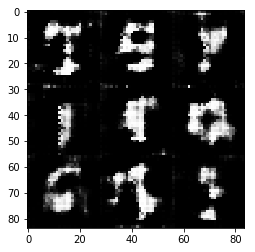

Epoch 1/2... Discriminator Loss: 2.7392... Generator Loss: 0.1271
Epoch 1/2... Discriminator Loss: 2.8323... Generator Loss: 0.5990
Epoch 1/2... Discriminator Loss: 2.3689... Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 3.3451... Generator Loss: 0.0641
Epoch 1/2... Discriminator Loss: 2.3749... Generator Loss: 1.3750
Epoch 1/2... Discriminator Loss: 2.4780... Generator Loss: 0.1394
Epoch 1/2... Discriminator Loss: 1.7278... Generator Loss: 1.3440
Epoch 1/2... Discriminator Loss: 1.8599... Generator Loss: 0.5797
Epoch 1/2... Discriminator Loss: 1.9006... Generator Loss: 0.5300
Epoch 1/2... Discriminator Loss: 1.8904... Generator Loss: 0.4980


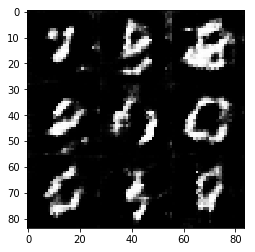

Epoch 1/2... Discriminator Loss: 1.7466... Generator Loss: 0.7528
Epoch 1/2... Discriminator Loss: 1.7977... Generator Loss: 0.5791
Epoch 1/2... Discriminator Loss: 1.7233... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 2.0141... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 1.7984... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 1.5090... Generator Loss: 1.0945
Epoch 1/2... Discriminator Loss: 1.7628... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 2.2732... Generator Loss: 0.2216
Epoch 1/2... Discriminator Loss: 2.2055... Generator Loss: 0.2097
Epoch 1/2... Discriminator Loss: 2.2552... Generator Loss: 0.1878


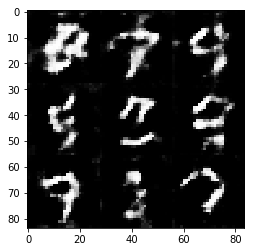

Epoch 1/2... Discriminator Loss: 1.8529... Generator Loss: 0.3012
Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.4060
Epoch 1/2... Discriminator Loss: 1.8426... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.4882... Generator Loss: 0.5944
Epoch 1/2... Discriminator Loss: 1.7123... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.7613... Generator Loss: 0.5909
Epoch 1/2... Discriminator Loss: 2.2778... Generator Loss: 0.1632
Epoch 1/2... Discriminator Loss: 1.9495... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 1.5674... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 2.0907... Generator Loss: 0.2146


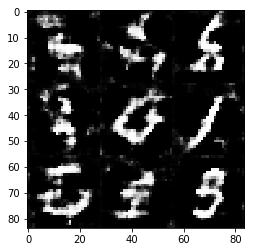

Epoch 1/2... Discriminator Loss: 1.8196... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.7551... Generator Loss: 0.9706
Epoch 1/2... Discriminator Loss: 1.6842... Generator Loss: 0.8892
Epoch 1/2... Discriminator Loss: 1.9976... Generator Loss: 0.2319
Epoch 1/2... Discriminator Loss: 1.7087... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 2.0004... Generator Loss: 0.3428
Epoch 1/2... Discriminator Loss: 2.0518... Generator Loss: 0.2526
Epoch 1/2... Discriminator Loss: 1.9774... Generator Loss: 0.2799
Epoch 1/2... Discriminator Loss: 2.2602... Generator Loss: 0.1828
Epoch 1/2... Discriminator Loss: 1.8671... Generator Loss: 0.3238


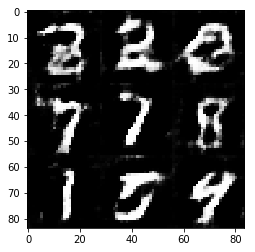

Epoch 1/2... Discriminator Loss: 1.9895... Generator Loss: 0.2312
Epoch 1/2... Discriminator Loss: 1.9379... Generator Loss: 0.2575
Epoch 1/2... Discriminator Loss: 1.7119... Generator Loss: 0.4744
Epoch 1/2... Discriminator Loss: 1.7647... Generator Loss: 0.3404
Epoch 1/2... Discriminator Loss: 2.3410... Generator Loss: 0.1638
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.5210
Epoch 1/2... Discriminator Loss: 1.7910... Generator Loss: 0.4458
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 2.1499... Generator Loss: 0.2230
Epoch 1/2... Discriminator Loss: 1.6330... Generator Loss: 0.8087


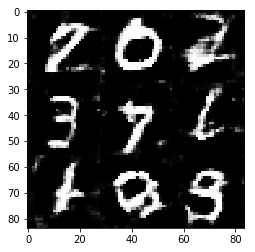

Epoch 1/2... Discriminator Loss: 2.3603... Generator Loss: 0.1807
Epoch 1/2... Discriminator Loss: 1.7957... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.9390... Generator Loss: 0.2763
Epoch 1/2... Discriminator Loss: 1.7540... Generator Loss: 1.2144
Epoch 1/2... Discriminator Loss: 1.7740... Generator Loss: 0.4886
Epoch 1/2... Discriminator Loss: 1.9815... Generator Loss: 0.2520
Epoch 1/2... Discriminator Loss: 2.9417... Generator Loss: 0.1049
Epoch 1/2... Discriminator Loss: 1.6478... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 2.1058... Generator Loss: 0.2508


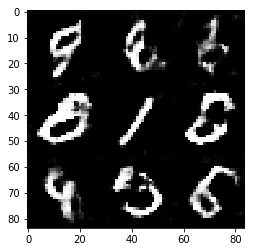

Epoch 1/2... Discriminator Loss: 2.1471... Generator Loss: 0.2174
Epoch 1/2... Discriminator Loss: 1.5766... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.8940... Generator Loss: 0.3114
Epoch 1/2... Discriminator Loss: 1.7419... Generator Loss: 0.4287
Epoch 1/2... Discriminator Loss: 1.7313... Generator Loss: 0.5197
Epoch 1/2... Discriminator Loss: 2.0304... Generator Loss: 0.3065
Epoch 1/2... Discriminator Loss: 1.8405... Generator Loss: 0.4051
Epoch 1/2... Discriminator Loss: 2.1440... Generator Loss: 0.2033
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 2.2013... Generator Loss: 0.2405


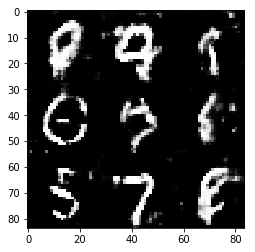

Epoch 1/2... Discriminator Loss: 1.6799... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.5425
Epoch 1/2... Discriminator Loss: 1.5217... Generator Loss: 0.6294
Epoch 1/2... Discriminator Loss: 1.9095... Generator Loss: 0.3020
Epoch 1/2... Discriminator Loss: 2.6513... Generator Loss: 0.1329
Epoch 1/2... Discriminator Loss: 1.9964... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 1.7159... Generator Loss: 0.3709
Epoch 1/2... Discriminator Loss: 1.8961... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.9881... Generator Loss: 0.2414
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.9610


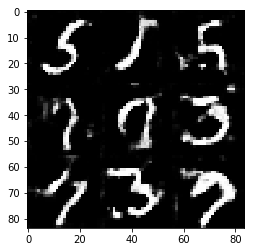

Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5939
Epoch 1/2... Discriminator Loss: 1.5468... Generator Loss: 0.5463
Epoch 1/2... Discriminator Loss: 1.9885... Generator Loss: 0.2693
Epoch 1/2... Discriminator Loss: 1.4409... Generator Loss: 1.1412
Epoch 1/2... Discriminator Loss: 2.3655... Generator Loss: 0.1635
Epoch 1/2... Discriminator Loss: 1.9005... Generator Loss: 0.3619
Epoch 1/2... Discriminator Loss: 3.0714... Generator Loss: 0.0860
Epoch 1/2... Discriminator Loss: 2.8680... Generator Loss: 0.1142
Epoch 1/2... Discriminator Loss: 1.6021... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.3681


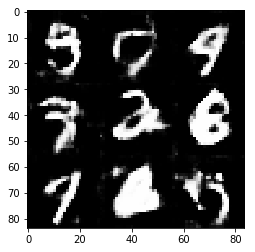

Epoch 1/2... Discriminator Loss: 2.2394... Generator Loss: 0.1835
Epoch 1/2... Discriminator Loss: 1.7435... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.6248... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.6338... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 2.0271... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.7538... Generator Loss: 0.3524
Epoch 1/2... Discriminator Loss: 1.8837... Generator Loss: 0.2771
Epoch 1/2... Discriminator Loss: 2.3572... Generator Loss: 0.1679
Epoch 1/2... Discriminator Loss: 1.7647... Generator Loss: 0.3555


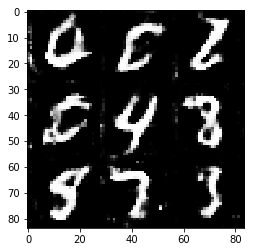

Epoch 1/2... Discriminator Loss: 1.6158... Generator Loss: 0.4540
Epoch 1/2... Discriminator Loss: 3.0620... Generator Loss: 0.0945
Epoch 1/2... Discriminator Loss: 1.9323... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 1.8053... Generator Loss: 0.3227
Epoch 1/2... Discriminator Loss: 2.3773... Generator Loss: 0.1637
Epoch 1/2... Discriminator Loss: 1.6142... Generator Loss: 0.3911
Epoch 1/2... Discriminator Loss: 2.3274... Generator Loss: 1.7170
Epoch 1/2... Discriminator Loss: 1.6002... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.5864... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.8893... Generator Loss: 0.2844


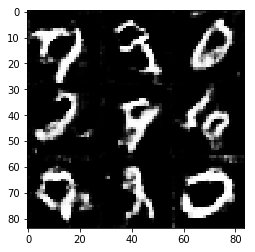

Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.5182
Epoch 1/2... Discriminator Loss: 1.5674... Generator Loss: 0.4940
Epoch 1/2... Discriminator Loss: 2.2301... Generator Loss: 0.1910
Epoch 1/2... Discriminator Loss: 1.6520... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 3.9236... Generator Loss: 0.0553
Epoch 1/2... Discriminator Loss: 1.9163... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 2.1007... Generator Loss: 0.3232
Epoch 1/2... Discriminator Loss: 2.8198... Generator Loss: 0.1039
Epoch 1/2... Discriminator Loss: 2.3354... Generator Loss: 0.1899
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 0.5654


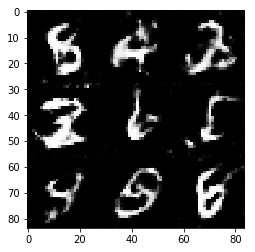

Epoch 1/2... Discriminator Loss: 1.8813... Generator Loss: 0.3240
Epoch 1/2... Discriminator Loss: 2.5436... Generator Loss: 0.1374
Epoch 1/2... Discriminator Loss: 2.3172... Generator Loss: 0.2307
Epoch 1/2... Discriminator Loss: 2.3309... Generator Loss: 0.2161
Epoch 1/2... Discriminator Loss: 2.4645... Generator Loss: 0.1610
Epoch 1/2... Discriminator Loss: 3.0716... Generator Loss: 0.1035
Epoch 1/2... Discriminator Loss: 1.6363... Generator Loss: 1.5064
Epoch 1/2... Discriminator Loss: 1.7135... Generator Loss: 0.4044
Epoch 1/2... Discriminator Loss: 2.0342... Generator Loss: 0.2402
Epoch 1/2... Discriminator Loss: 2.4235... Generator Loss: 0.1936


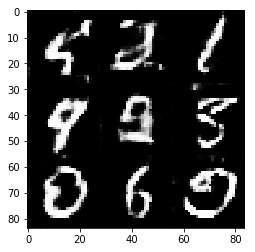

Epoch 1/2... Discriminator Loss: 2.0594... Generator Loss: 0.2761
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 2.1635... Generator Loss: 0.2127
Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 1.8847... Generator Loss: 0.3365
Epoch 1/2... Discriminator Loss: 2.1766... Generator Loss: 0.2132
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.8593... Generator Loss: 0.8313
Epoch 1/2... Discriminator Loss: 1.8120... Generator Loss: 0.3275
Epoch 1/2... Discriminator Loss: 1.1795... Generator Loss: 0.7786


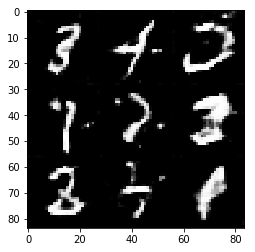

Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 0.5079
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.1468... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 2.8771... Generator Loss: 0.1236
Epoch 1/2... Discriminator Loss: 2.8896... Generator Loss: 0.1118
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 1.4010
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 2.7274... Generator Loss: 0.1660


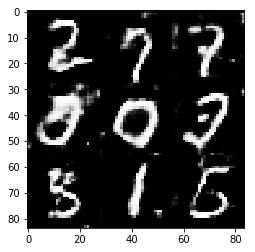

Epoch 1/2... Discriminator Loss: 2.0992... Generator Loss: 0.3061
Epoch 1/2... Discriminator Loss: 1.6939... Generator Loss: 0.3927
Epoch 1/2... Discriminator Loss: 2.2240... Generator Loss: 0.1903
Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 0.3713
Epoch 1/2... Discriminator Loss: 2.3179... Generator Loss: 0.1937
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.9380... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 1.9924... Generator Loss: 0.3290
Epoch 1/2... Discriminator Loss: 2.9084... Generator Loss: 0.1247
Epoch 1/2... Discriminator Loss: 2.3244... Generator Loss: 0.2146


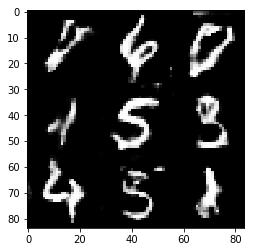

Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 1.0964
Epoch 1/2... Discriminator Loss: 2.6632... Generator Loss: 0.1427
Epoch 1/2... Discriminator Loss: 1.7973... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 2.5008... Generator Loss: 0.1816
Epoch 1/2... Discriminator Loss: 2.0534... Generator Loss: 0.2465
Epoch 1/2... Discriminator Loss: 1.7179... Generator Loss: 0.4581
Epoch 1/2... Discriminator Loss: 1.6604... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 1.9025... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.7477
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.5282


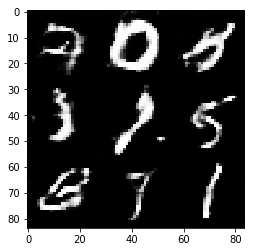

Epoch 1/2... Discriminator Loss: 2.0705... Generator Loss: 0.2574
Epoch 1/2... Discriminator Loss: 1.9233... Generator Loss: 0.2917
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 2.7194... Generator Loss: 0.1431
Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.3796
Epoch 1/2... Discriminator Loss: 1.9787... Generator Loss: 0.2875
Epoch 1/2... Discriminator Loss: 2.6194... Generator Loss: 0.1415
Epoch 2/2... Discriminator Loss: 3.8079... Generator Loss: 0.0550
Epoch 2/2... Discriminator Loss: 1.8464... Generator Loss: 3.3021
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.5603


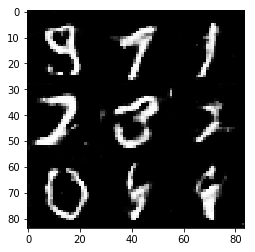

Epoch 2/2... Discriminator Loss: 1.7469... Generator Loss: 0.4468
Epoch 2/2... Discriminator Loss: 1.7828... Generator Loss: 0.3555
Epoch 2/2... Discriminator Loss: 1.8637... Generator Loss: 0.2998
Epoch 2/2... Discriminator Loss: 2.2924... Generator Loss: 0.1891
Epoch 2/2... Discriminator Loss: 2.4071... Generator Loss: 0.1922
Epoch 2/2... Discriminator Loss: 2.7591... Generator Loss: 0.1499
Epoch 2/2... Discriminator Loss: 2.3049... Generator Loss: 0.2790
Epoch 2/2... Discriminator Loss: 3.4573... Generator Loss: 0.0664
Epoch 2/2... Discriminator Loss: 2.8089... Generator Loss: 0.1307
Epoch 2/2... Discriminator Loss: 1.9166... Generator Loss: 0.3385


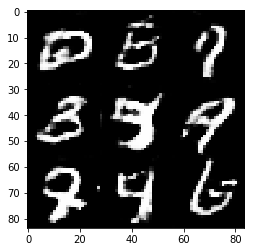

Epoch 2/2... Discriminator Loss: 1.6310... Generator Loss: 0.4286
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 1.2747
Epoch 2/2... Discriminator Loss: 2.7551... Generator Loss: 0.1373
Epoch 2/2... Discriminator Loss: 2.2544... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 2.2858... Generator Loss: 0.2218
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.1802
Epoch 2/2... Discriminator Loss: 2.5384... Generator Loss: 0.1470
Epoch 2/2... Discriminator Loss: 1.4939... Generator Loss: 0.4712
Epoch 2/2... Discriminator Loss: 1.5273... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.9684... Generator Loss: 0.2965


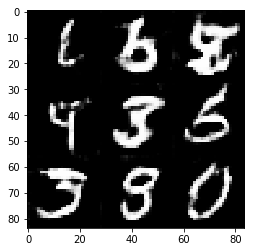

Epoch 2/2... Discriminator Loss: 1.8622... Generator Loss: 0.3057
Epoch 2/2... Discriminator Loss: 2.6506... Generator Loss: 0.1606
Epoch 2/2... Discriminator Loss: 1.9826... Generator Loss: 0.2829
Epoch 2/2... Discriminator Loss: 2.4319... Generator Loss: 0.1526
Epoch 2/2... Discriminator Loss: 1.7486... Generator Loss: 0.3695
Epoch 2/2... Discriminator Loss: 2.7648... Generator Loss: 0.1315
Epoch 2/2... Discriminator Loss: 2.7527... Generator Loss: 0.1139
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.8417... Generator Loss: 0.3994
Epoch 2/2... Discriminator Loss: 2.7240... Generator Loss: 0.1485


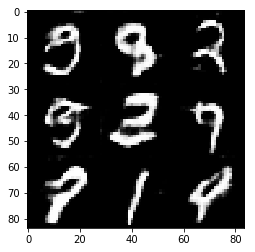

Epoch 2/2... Discriminator Loss: 1.4984... Generator Loss: 0.5310
Epoch 2/2... Discriminator Loss: 2.7724... Generator Loss: 0.1293
Epoch 2/2... Discriminator Loss: 3.0894... Generator Loss: 0.1071
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 1.4009... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 2.2875... Generator Loss: 0.2011
Epoch 2/2... Discriminator Loss: 2.0486... Generator Loss: 0.2445
Epoch 2/2... Discriminator Loss: 1.8619... Generator Loss: 0.3104
Epoch 2/2... Discriminator Loss: 1.8538... Generator Loss: 0.3141


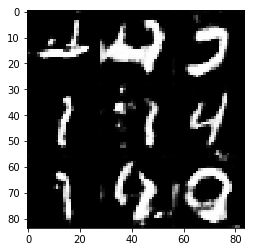

Epoch 2/2... Discriminator Loss: 2.0369... Generator Loss: 0.3548
Epoch 2/2... Discriminator Loss: 2.8284... Generator Loss: 0.1324
Epoch 2/2... Discriminator Loss: 1.7170... Generator Loss: 0.3687
Epoch 2/2... Discriminator Loss: 1.7178... Generator Loss: 0.4394
Epoch 2/2... Discriminator Loss: 3.2830... Generator Loss: 0.0997
Epoch 2/2... Discriminator Loss: 2.0555... Generator Loss: 0.2432
Epoch 2/2... Discriminator Loss: 1.4035... Generator Loss: 0.5265
Epoch 2/2... Discriminator Loss: 1.9235... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 2.0068... Generator Loss: 0.2924
Epoch 2/2... Discriminator Loss: 1.9476... Generator Loss: 0.4238


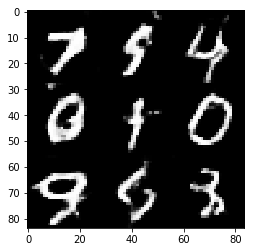

Epoch 2/2... Discriminator Loss: 2.2157... Generator Loss: 0.2247
Epoch 2/2... Discriminator Loss: 1.5205... Generator Loss: 1.7522
Epoch 2/2... Discriminator Loss: 3.4104... Generator Loss: 0.0723
Epoch 2/2... Discriminator Loss: 4.2793... Generator Loss: 0.0351
Epoch 2/2... Discriminator Loss: 2.5451... Generator Loss: 0.1817
Epoch 2/2... Discriminator Loss: 1.5511... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 2.6012... Generator Loss: 0.1456
Epoch 2/2... Discriminator Loss: 2.2245... Generator Loss: 0.2145
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.7670
Epoch 2/2... Discriminator Loss: 1.5924... Generator Loss: 0.5016


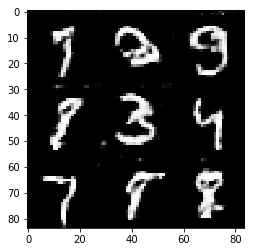

Epoch 2/2... Discriminator Loss: 3.0306... Generator Loss: 0.1094
Epoch 2/2... Discriminator Loss: 2.7147... Generator Loss: 0.1472
Epoch 2/2... Discriminator Loss: 1.8708... Generator Loss: 0.3064
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 2.1014... Generator Loss: 0.2725
Epoch 2/2... Discriminator Loss: 2.7656... Generator Loss: 0.1324
Epoch 2/2... Discriminator Loss: 1.3336... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 1.6471... Generator Loss: 0.3909
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.9949


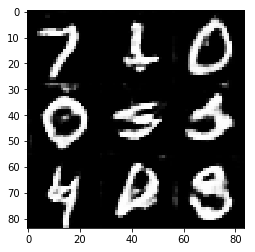

Epoch 2/2... Discriminator Loss: 2.6119... Generator Loss: 0.2054
Epoch 2/2... Discriminator Loss: 1.1583... Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 2.1603... Generator Loss: 0.2398
Epoch 2/2... Discriminator Loss: 1.6718... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 2.4073... Generator Loss: 0.1880
Epoch 2/2... Discriminator Loss: 2.1476... Generator Loss: 0.3389
Epoch 2/2... Discriminator Loss: 2.8860... Generator Loss: 0.1186
Epoch 2/2... Discriminator Loss: 2.6328... Generator Loss: 0.1640
Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 2.1474
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 1.0122


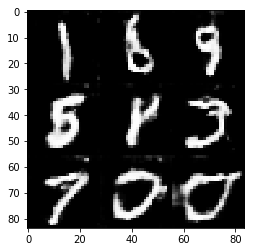

Epoch 2/2... Discriminator Loss: 1.0287... Generator Loss: 1.4234
Epoch 2/2... Discriminator Loss: 1.4585... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 2.6810... Generator Loss: 0.1324
Epoch 2/2... Discriminator Loss: 2.6576... Generator Loss: 0.1806
Epoch 2/2... Discriminator Loss: 2.7952... Generator Loss: 0.1320
Epoch 2/2... Discriminator Loss: 3.3092... Generator Loss: 0.1055
Epoch 2/2... Discriminator Loss: 2.0559... Generator Loss: 0.2369
Epoch 2/2... Discriminator Loss: 2.1241... Generator Loss: 0.2714
Epoch 2/2... Discriminator Loss: 1.4358... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.4651


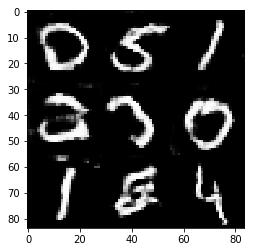

Epoch 2/2... Discriminator Loss: 2.8105... Generator Loss: 0.1321
Epoch 2/2... Discriminator Loss: 2.3020... Generator Loss: 0.2144
Epoch 2/2... Discriminator Loss: 1.1064... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.5370... Generator Loss: 0.4926
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.5000
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.8357
Epoch 2/2... Discriminator Loss: 1.7904... Generator Loss: 0.3507
Epoch 2/2... Discriminator Loss: 1.7490... Generator Loss: 0.3944
Epoch 2/2... Discriminator Loss: 1.9789... Generator Loss: 0.2916
Epoch 2/2... Discriminator Loss: 1.7518... Generator Loss: 0.3814


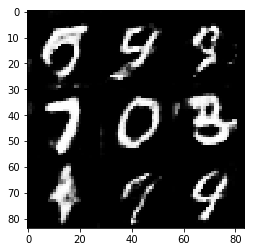

Epoch 2/2... Discriminator Loss: 3.0137... Generator Loss: 0.1017
Epoch 2/2... Discriminator Loss: 2.6830... Generator Loss: 0.1492
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 2.5399
Epoch 2/2... Discriminator Loss: 2.5826... Generator Loss: 0.1648
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.2290... Generator Loss: 0.7612
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.9949
Epoch 2/2... Discriminator Loss: 1.6147... Generator Loss: 0.4292
Epoch 2/2... Discriminator Loss: 2.9921... Generator Loss: 0.1203


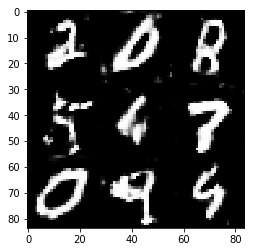

Epoch 2/2... Discriminator Loss: 3.0246... Generator Loss: 0.1024
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.6100
Epoch 2/2... Discriminator Loss: 2.2891... Generator Loss: 0.2118
Epoch 2/2... Discriminator Loss: 2.8558... Generator Loss: 0.1249
Epoch 2/2... Discriminator Loss: 1.8069... Generator Loss: 2.0711
Epoch 2/2... Discriminator Loss: 2.2097... Generator Loss: 0.2054
Epoch 2/2... Discriminator Loss: 3.1878... Generator Loss: 0.0786
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 1.6153... Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.6756


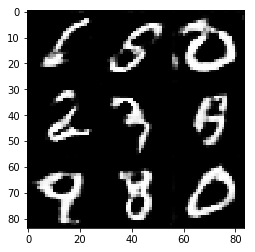

Epoch 2/2... Discriminator Loss: 2.1073... Generator Loss: 0.5175
Epoch 2/2... Discriminator Loss: 1.6600... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.9074... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.7867... Generator Loss: 0.4421
Epoch 2/2... Discriminator Loss: 2.2579... Generator Loss: 0.2232
Epoch 2/2... Discriminator Loss: 4.8855... Generator Loss: 0.0327
Epoch 2/2... Discriminator Loss: 2.1470... Generator Loss: 0.2310
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 0.5677
Epoch 2/2... Discriminator Loss: 2.0991... Generator Loss: 0.3049
Epoch 2/2... Discriminator Loss: 1.7236... Generator Loss: 0.5479


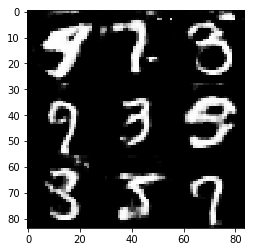

Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.5938
Epoch 2/2... Discriminator Loss: 1.6541... Generator Loss: 0.4066
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.6213... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 1.7768... Generator Loss: 0.3753
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 2.0103... Generator Loss: 0.2705


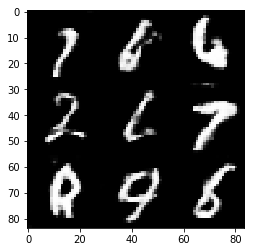

Epoch 2/2... Discriminator Loss: 1.8024... Generator Loss: 0.3206
Epoch 2/2... Discriminator Loss: 2.1170... Generator Loss: 0.2455
Epoch 2/2... Discriminator Loss: 2.0708... Generator Loss: 0.2407
Epoch 2/2... Discriminator Loss: 1.0381... Generator Loss: 0.9888
Epoch 2/2... Discriminator Loss: 0.8327... Generator Loss: 1.2710
Epoch 2/2... Discriminator Loss: 1.6025... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 3.5775... Generator Loss: 0.0695
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 2.2729... Generator Loss: 0.2273


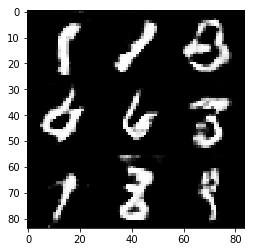

Epoch 2/2... Discriminator Loss: 1.5984... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 1.6275... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 3.0229... Generator Loss: 0.1575
Epoch 2/2... Discriminator Loss: 2.5913... Generator Loss: 0.1394
Epoch 2/2... Discriminator Loss: 1.8704... Generator Loss: 0.3338
Epoch 2/2... Discriminator Loss: 1.6162... Generator Loss: 0.4823
Epoch 2/2... Discriminator Loss: 1.8099... Generator Loss: 0.3554
Epoch 2/2... Discriminator Loss: 2.5255... Generator Loss: 0.1659
Epoch 2/2... Discriminator Loss: 1.8804... Generator Loss: 0.4880
Epoch 2/2... Discriminator Loss: 2.1605... Generator Loss: 0.2675


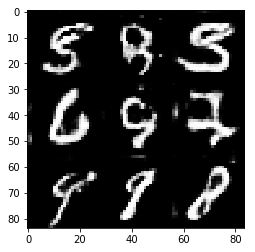

Epoch 2/2... Discriminator Loss: 2.2816... Generator Loss: 0.2298
Epoch 2/2... Discriminator Loss: 1.8252... Generator Loss: 0.2983
Epoch 2/2... Discriminator Loss: 1.9140... Generator Loss: 0.3078
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.9228... Generator Loss: 0.3726
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.8028... Generator Loss: 0.3300
Epoch 2/2... Discriminator Loss: 1.5162... Generator Loss: 1.9554
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.6103


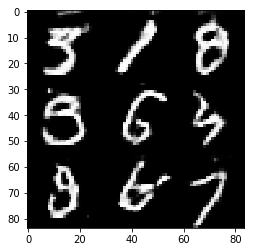

Epoch 2/2... Discriminator Loss: 2.5386... Generator Loss: 0.1419
Epoch 2/2... Discriminator Loss: 1.6791... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 2.2942... Generator Loss: 0.2412
Epoch 2/2... Discriminator Loss: 3.2612... Generator Loss: 0.1200
Epoch 2/2... Discriminator Loss: 1.8357... Generator Loss: 0.3565


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.01
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 2.6694
Epoch 1/1... Discriminator Loss: 1.8031... Generator Loss: 6.5393
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 3.0921
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.9201


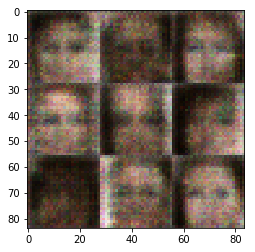

Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6231
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 3.2777
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 1.8487... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 1.9293... Generator Loss: 0.2751
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 1.2397


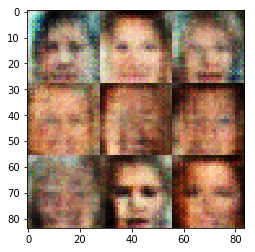

Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 1.4692
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 1.5644
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 1.6113
Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.1534


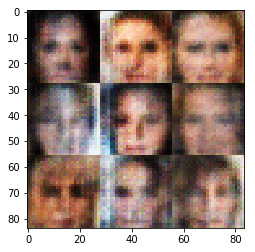

Epoch 1/1... Discriminator Loss: 1.8421... Generator Loss: 0.3090
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9643


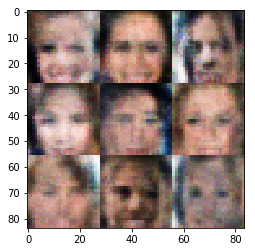

Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.0075


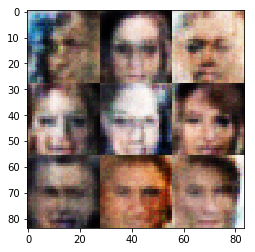

Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.9602


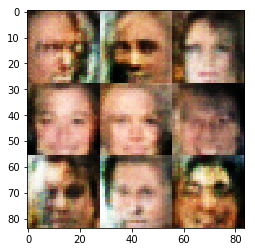

Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.3042
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.9392


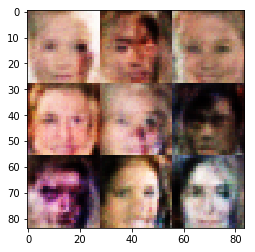

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5993


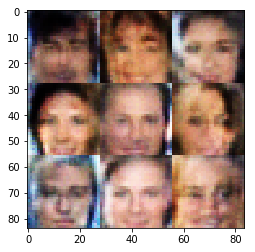

Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.4860


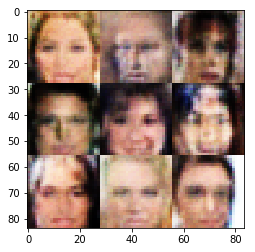

Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7800


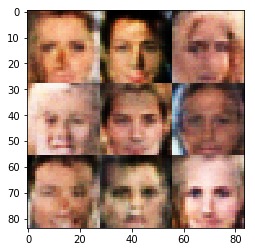

Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6063
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.8924
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.7174... Generator Loss: 0.3458
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.7440


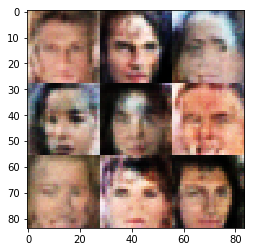

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.9874


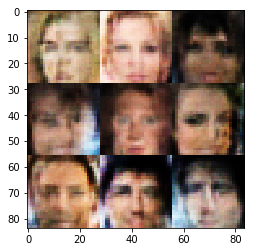

Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.4294


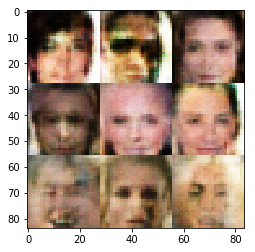

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.4400
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.5691... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6337


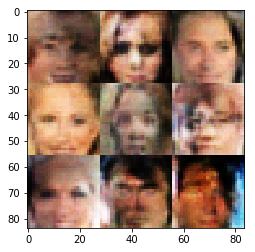

Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6097


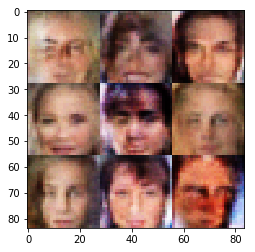

Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.1798
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.4730


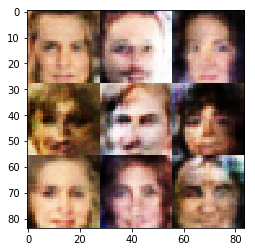

Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6135


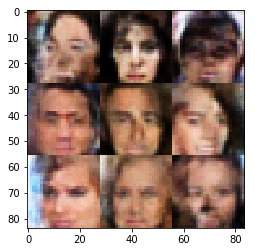

Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 1.5791
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.9056... Generator Loss: 0.2694
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.4345


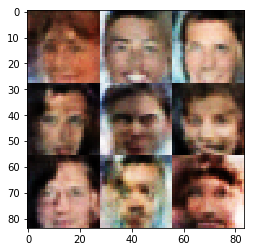

Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 1.2836
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.4319
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6311


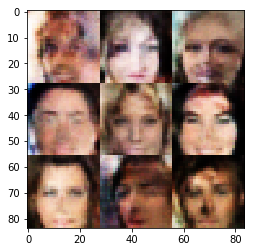

Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.7718


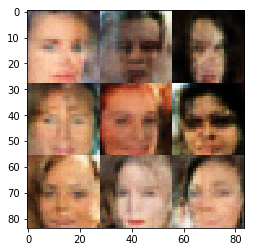

Epoch 1/1... Discriminator Loss: 1.5771... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 1.0291


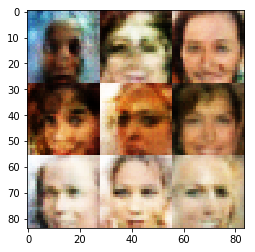

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.6263... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.7562... Generator Loss: 0.3160
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.5308


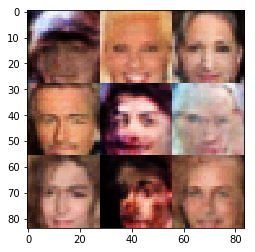

Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9177


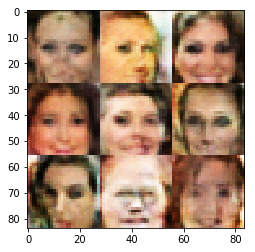

Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.6468


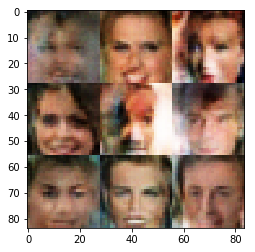

Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.4153
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.4371
Epoch 1/1... Discriminator Loss: 1.7176... Generator Loss: 0.3162


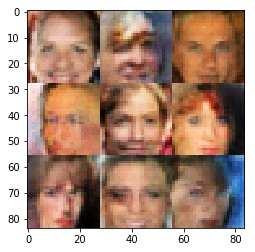

Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.4439
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 1.6836
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.6450


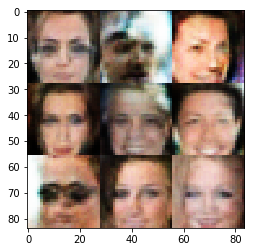

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.6928... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.4403
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.5870


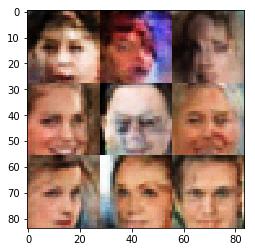

Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.7839... Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 1.3828
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.5629


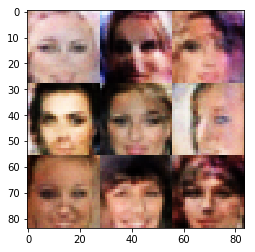

Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 1.4110
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.7351... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.5418


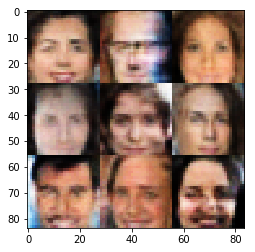

Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.4274
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4593


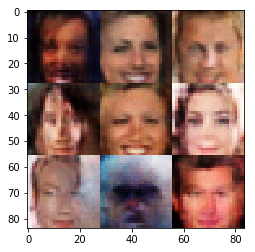

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.8170
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.4341
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0586


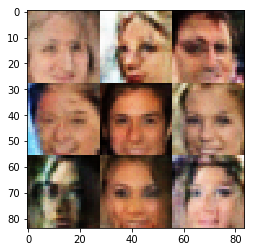

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.3568
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6553


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.